# Кластеризация ЕГЭ (4 если сделаны все задачи)

Рядом лежат данные с координатами точек. Везде используется Евклидово расстояние. Кластером считается набор не менее чем из 30 точек связанных друг с другом. Аномалия это точка находящаяся на расстоянии более 1 от любого кластера.

* Постройте Распределение точек
* Напишите руками DBSCAN и обработайте им все файлы
* Файл 0.xls также решите руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Отметьте Аномалии отдельным цветом
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите два числа - Среднее абсцисс и ординат центроидов кластеров * 100000

0.xls 126063.37070465088 34710.899988810226


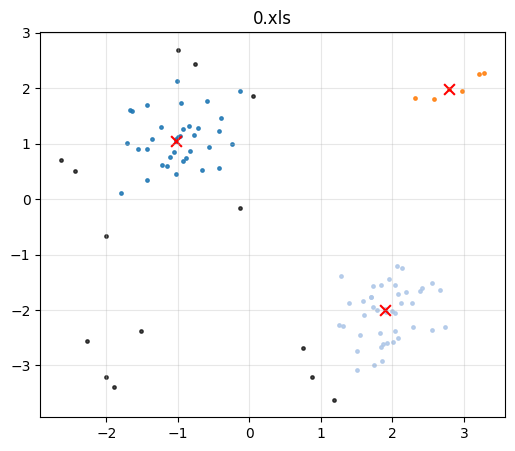

1.xls 99844.26101048788 99805.04115422568


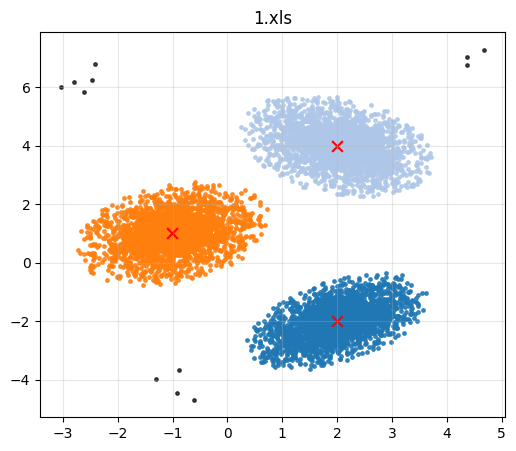

2.txt 519494.96269226074 495410.3469848633


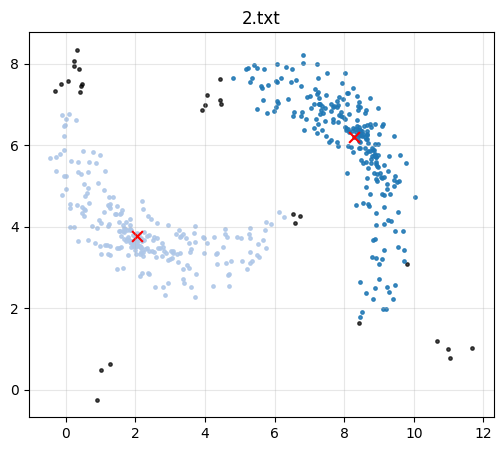

3.txt 472197.3856290181 404551.3053735097


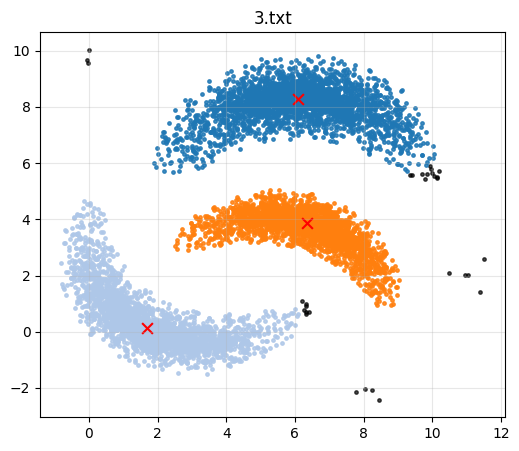

KeyError: 'X'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

names = ["0.xls", "1.xls", "2.txt", "3.txt", "4.txt", "5.txt"]

PARAMS = {
    "0.xls": (0.55, 5),
    "1.xls": (0.45, 40),
    "2.txt": (0.65, 10),
    "3.txt": (0.60, 30),
    "4.txt": (0.50, 10),
    "5.txt": (0.55, 50),
}

for name in names:
    df = pd.read_excel(name) if name.endswith(".xls") else pd.read_csv(name)

    x = df["X"].to_numpy(dtype=np.float32, copy=False)
    y = df["Y"].to_numpy(dtype=np.float32, copy=False)
    XY = np.column_stack([x, y]).astype(np.float32, copy=False)

    eps, min_samples = PARAMS[name]

    D = cdist(XY, XY).astype(np.float32, copy=False)
    neigh = D <= np.float32(eps)

    n = XY.shape[0]
    labels = np.full(n, -2, dtype=np.int32)
    visited = np.zeros(n, dtype=bool)
    cid = 0

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        Ni = np.flatnonzero(neigh[i])
        if Ni.size < min_samples:
            labels[i] = -1
            continue
        labels[i] = cid
        q = list(Ni)
        while q:
            j = q.pop()
            if not visited[j]:
                visited[j] = True
                Nj = np.flatnonzero(neigh[j])
                if Nj.size >= min_samples:
                    q.extend(Nj.tolist())
            if labels[j] in (-2, -1):
                labels[j] = cid
        cid += 1

    clusters = np.unique(labels)
    clusters = clusters[clusters != -1]

    centroids = []
    medoids = []

    for k in clusters:
        idx = np.flatnonzero(labels == k)
        P = XY[idx]
        centroids.append(P.mean(axis=0))
        d = cdist(P, P)
        medoids.append(idx[int(np.argmin(d.sum(axis=1)))])

    centroids = np.array(centroids, dtype=np.float64)
    if centroids.size:
        mx, my = (centroids.mean(axis=0) * 100000.0)
        print(name, mx, my)
    else:
        print(name, "no_clusters")

    plt.figure(figsize=(6, 5))
    noise = labels == -1
    plt.scatter(x[noise], y[noise], s=6, c="k", alpha=0.7)

    cmap = plt.get_cmap("tab20")
    for t, k in enumerate(clusters):
        m = labels == k
        plt.scatter(x[m], y[m], s=6, color=cmap(t % 20), alpha=0.85)

    if medoids:
        mi = np.array(medoids, dtype=np.int32)
        plt.scatter(x[mi], y[mi], marker="x", s=60, color="red")

    plt.title(name)
    plt.grid(True, alpha=0.3)
    plt.show()

# Кластеризация (1 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [ ]:
two_means =  
dbscan = 

clustering_algorithms = (
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("OPTICS", optics),
        ("Gaussian\nMixture", gmm),
    )

In [ ]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()